In [168]:
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import itertools

In [169]:
df_data = pd.read_csv('../data/train.csv')
df_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [170]:
X = df_data.copy().drop(['id', 'species'],axis='columns').values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1

In [185]:
device = torch.device('cpu')
if torch.backends.cuda.is_built():
    device = torch.device('cuda')

In [190]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
t_train = torch.tensor(t_train, dtype=torch.float32, device=device)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

In [237]:
def training_MLP(X_train, t_train, X_test, t_test, loss_function, optimizer, num_epochs=1, verbose=False):
    accuracy_train = []
    loss_train = []
    accuracy_test = []
    loss_test = []
    for epoch in range(num_epochs):
        accuracy = 0
        loss_epoch = 0
        for (x_sample, t_sample) in zip(X_train, t_train): # Dans une epoch nous parcourons toutes les données
            y = model(x_sample)
            loss = loss_function(y, t_sample)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            accuracy += (torch.argmax(y) == torch.argmax(t_sample))
        accuracy = accuracy / X_train.shape[0]
        loss_train.append(loss_epoch / X_train.shape[0])
        accuracy_train.append(accuracy)
        
        y_test = model(X_test)
        loss = loss_function(y_test, t_test)
        loss_test.append(loss.item())
        accuracy_test.append(torch.sum(torch.eq(torch.argmax(y_test, dim=1), torch.argmax(t_test, dim=1))).item() / X_test.shape[0])
        if verbose:
            print("Epoch {}/{}, Loss: {:.5f}, Accuracy: {:.2f}%".format(epoch+1, num_epochs, loss_train[-1], accuracy_train[-1]*100))
        
        # Convergence de l'algorithme ça ne sert à rien de continuer à faire des calculs
        if len(loss_train) >= 2 and abs(loss_train[-1] - loss_train[-2]) <= 1e-4: 
            break
        
        # si nous avons une précision supérieure à 99% nous arrêtons l'entraînement car nous sommes en train de
        # faire du surapprentissage
        #if accuracy >= 0.99: 
         #   break
    return loss_train, accuracy_train, loss_test, accuracy_test

In [256]:
def plot_training(loss_train, accuracy_train, loss_test, accuracy_test):
    xdata = np.arange(1, len(loss_train) + 1)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.ylabel('Loss')
    plt.plot(xdata, loss_train, label='training')
    plt.plot(xdata, loss_test, label='validation')
    plt.xticks(xdata)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.ylabel('Accuracy')
    plt.plot(xdata, accuracy_train, label='training')
    plt.plot(xdata, accuracy_test, label='validation')
    plt.xticks(xdata)
    plt.legend()
    plt.show(block=False)

In [257]:
def reset_model_params(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

## Création du model

In [258]:
# X.shape[1] : le nombre de caractéristiques
model = nn.Sequential(
    nn.Linear(X.shape[1], 96, bias=True, dtype=torch.float32), # couche d'entrée
    nn.ReLU(),
    nn.Linear(96, 96, bias=True, dtype=torch.float32), # couche cachée
    nn.ReLU(),
    nn.Linear(96, species.size, bias=True, dtype=torch.float32), # couche de sortie
)
model.to(device=device)

Sequential(
  (0): Linear(in_features=192, out_features=96, bias=True)
  (1): ReLU()
  (2): Linear(in_features=96, out_features=96, bias=True)
  (3): ReLU()
  (4): Linear(in_features=96, out_features=99, bias=True)
)

## Test d'entrainement via une descente de gradiant 

In [259]:
reset_model_params(model)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=500, verbose=True)

Epoch 1/500, Loss: 4.60467, Accuracy: 0.43%
Epoch 2/500, Loss: 4.59705, Accuracy: 1.01%
Epoch 3/500, Loss: 4.59200, Accuracy: 1.15%
Epoch 4/500, Loss: 4.58841, Accuracy: 1.15%
Epoch 5/500, Loss: 4.58560, Accuracy: 1.15%
Epoch 6/500, Loss: 4.58331, Accuracy: 1.15%
Epoch 7/500, Loss: 4.58128, Accuracy: 1.01%
Epoch 8/500, Loss: 4.57930, Accuracy: 1.01%
Epoch 9/500, Loss: 4.57716, Accuracy: 1.01%
Epoch 10/500, Loss: 4.57461, Accuracy: 1.44%
Epoch 11/500, Loss: 4.57138, Accuracy: 1.30%
Epoch 12/500, Loss: 4.56685, Accuracy: 1.30%
Epoch 13/500, Loss: 4.56011, Accuracy: 1.88%
Epoch 14/500, Loss: 4.54939, Accuracy: 2.60%
Epoch 15/500, Loss: 4.53113, Accuracy: 3.03%
Epoch 16/500, Loss: 4.49764, Accuracy: 3.75%
Epoch 17/500, Loss: 4.43532, Accuracy: 3.61%
Epoch 18/500, Loss: 4.33544, Accuracy: 3.90%
Epoch 19/500, Loss: 4.21837, Accuracy: 4.47%
Epoch 20/500, Loss: 4.10457, Accuracy: 4.18%
Epoch 21/500, Loss: 3.98581, Accuracy: 4.76%
Epoch 22/500, Loss: 3.84778, Accuracy: 6.35%
Epoch 23/500, Loss:

In [260]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 80.81% sur les données test


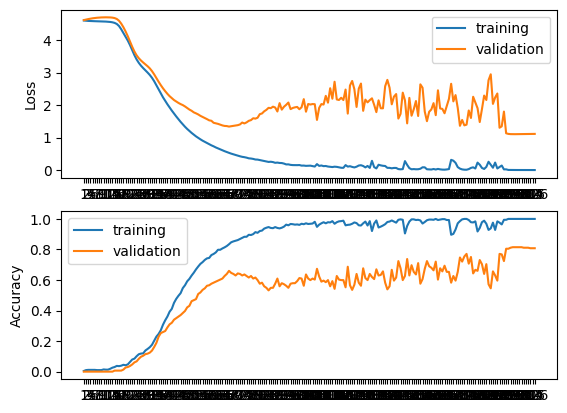

In [261]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

# Ajout d'un terme de régularisation

In [262]:
reset_model_params(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5, weight_decay=1e-3)
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=500, verbose=True)

Epoch 1/500, Loss: 4.60591, Accuracy: 0.58%
Epoch 2/500, Loss: 4.59793, Accuracy: 0.72%
Epoch 3/500, Loss: 4.59290, Accuracy: 0.58%
Epoch 4/500, Loss: 4.58936, Accuracy: 0.72%
Epoch 5/500, Loss: 4.58673, Accuracy: 1.01%
Epoch 6/500, Loss: 4.58483, Accuracy: 1.01%
Epoch 7/500, Loss: 4.58331, Accuracy: 1.15%
Epoch 8/500, Loss: 4.58201, Accuracy: 1.15%
Epoch 9/500, Loss: 4.58088, Accuracy: 1.30%
Epoch 10/500, Loss: 4.57976, Accuracy: 1.15%
Epoch 11/500, Loss: 4.57864, Accuracy: 1.15%
Epoch 12/500, Loss: 4.57743, Accuracy: 1.15%
Epoch 13/500, Loss: 4.57606, Accuracy: 1.44%
Epoch 14/500, Loss: 4.57445, Accuracy: 1.59%
Epoch 15/500, Loss: 4.57244, Accuracy: 1.88%
Epoch 16/500, Loss: 4.56977, Accuracy: 2.31%
Epoch 17/500, Loss: 4.56604, Accuracy: 2.60%
Epoch 18/500, Loss: 4.56054, Accuracy: 2.74%
Epoch 19/500, Loss: 4.55190, Accuracy: 2.74%
Epoch 20/500, Loss: 4.53748, Accuracy: 3.03%
Epoch 21/500, Loss: 4.51180, Accuracy: 3.03%
Epoch 22/500, Loss: 4.46531, Accuracy: 3.03%
Epoch 23/500, Loss:

In [263]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 67.68% sur les données test


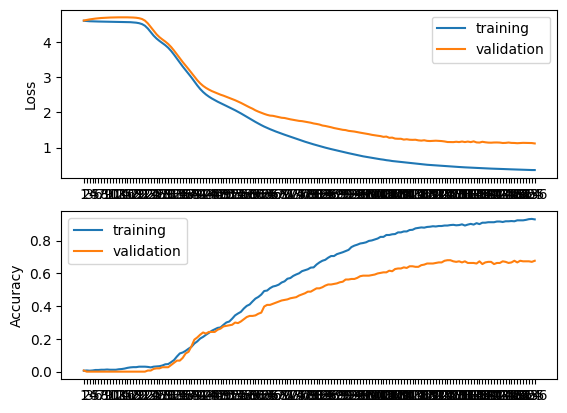

In [264]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

## Recherche des hyperparamètres

Nous réutilisons le code de la K-fold cross validation du TP4

In [265]:
lr_choices = [1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
reg_choices = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
K = 5
kf = KFold(n_splits=K, shuffle=True)

best_accu = -1
best_params = None
accuracy_historic = np.zeros((len(lr_choices), len(reg_choices)))

for i, lr in enumerate(lr_choices):
    for j, reg in enumerate(reg_choices):
        print("testing parameters: learning_rate = {:.0e},    regularization = {:.0e}".format(lr, reg))
        params = (lr, reg)
        val_accu = 0
        
        for k, (k_train_indice, k_val_indice) in enumerate(kf.split(X_train)):
            reset_model_params(model)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=reg)
            curves = training_MLP(
                X_train[k_train_indice], t_train[k_train_indice], X_train[k_val_indice], t_train[k_val_indice],
                loss_function, optimizer, num_epochs=1000)
            _, _, _, accuracy_validation = curves
            print('K = {}, accuracy: {:.3f}'.format(k, accuracy_validation[-1]))
            val_accu += accuracy_validation[-1]
        
        val_accu = val_accu / K
        accuracy_historic[i][j] = val_accu
        if val_accu > best_accu:
            print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
            best_accu = val_accu
            best_params = params

testing parameters: learning_rate = 1e-03,    regularization = 1e-02
K = 0, accuracy: 0.007
K = 1, accuracy: 0.000
K = 2, accuracy: 0.007
K = 3, accuracy: 0.000
K = 4, accuracy: 0.007
Best val accuracy: 0.004 | lr: 1e-03 | l2_reg: 1e-02
testing parameters: learning_rate = 1e-03,    regularization = 1e-03
K = 0, accuracy: 0.007
K = 1, accuracy: 0.007
K = 2, accuracy: 0.007
K = 3, accuracy: 0.000
K = 4, accuracy: 0.007
Best val accuracy: 0.006 | lr: 1e-03 | l2_reg: 1e-03
testing parameters: learning_rate = 1e-03,    regularization = 1e-04
K = 0, accuracy: 0.727
K = 1, accuracy: 0.784
K = 2, accuracy: 0.806
K = 3, accuracy: 0.674
K = 4, accuracy: 0.761
Best val accuracy: 0.750 | lr: 1e-03 | l2_reg: 1e-04
testing parameters: learning_rate = 1e-03,    regularization = 1e-05
K = 0, accuracy: 0.734
K = 1, accuracy: 0.719
K = 2, accuracy: 0.698
K = 3, accuracy: 0.783
K = 4, accuracy: 0.732
testing parameters: learning_rate = 1e-03,    regularization = 1e-06
K = 0, accuracy: 0.741
K = 1, accura

In [266]:
best_params

(0.001, 1e-06)

In [270]:
reset_model_params(model)
optimizer = torch.optim.SGD(model.parameters(), lr=best_params[0], momentum=0.5, weight_decay=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=2000, verbose=True)

Epoch 1/2000, Loss: 4.59725, Accuracy: 0.72%
Epoch 2/2000, Loss: 4.59610, Accuracy: 0.87%
Epoch 3/2000, Loss: 4.59501, Accuracy: 0.87%
Epoch 4/2000, Loss: 4.59396, Accuracy: 0.87%
Epoch 5/2000, Loss: 4.59297, Accuracy: 0.87%
Epoch 6/2000, Loss: 4.59202, Accuracy: 0.58%
Epoch 7/2000, Loss: 4.59111, Accuracy: 0.87%
Epoch 8/2000, Loss: 4.59023, Accuracy: 0.58%
Epoch 9/2000, Loss: 4.58940, Accuracy: 1.44%
Epoch 10/2000, Loss: 4.58860, Accuracy: 1.44%
Epoch 11/2000, Loss: 4.58783, Accuracy: 1.44%
Epoch 12/2000, Loss: 4.58708, Accuracy: 1.44%
Epoch 13/2000, Loss: 4.58636, Accuracy: 1.44%
Epoch 14/2000, Loss: 4.58566, Accuracy: 1.44%
Epoch 15/2000, Loss: 4.58497, Accuracy: 1.44%
Epoch 16/2000, Loss: 4.58431, Accuracy: 1.44%
Epoch 17/2000, Loss: 4.58367, Accuracy: 1.44%
Epoch 18/2000, Loss: 4.58305, Accuracy: 1.44%
Epoch 19/2000, Loss: 4.58244, Accuracy: 1.44%
Epoch 20/2000, Loss: 4.58185, Accuracy: 1.44%
Epoch 21/2000, Loss: 4.58128, Accuracy: 1.44%
Epoch 22/2000, Loss: 4.58072, Accuracy: 1.4

In [271]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 78.45% sur les données test


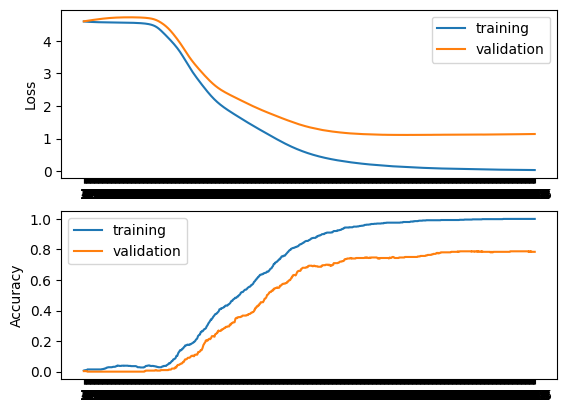

In [272]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)